Static prediction models for different prediction shapes
---------------------------------------------------------

This notebook demonstrates how to generate prediction for different spatial types:
1) points
2) polygons
3) blocks

 Averaging predictions over certain spatial block sizes or polygons (vector shapes) rather than using just point predictions can have certain advantages, such as a) typically reduces the predictive uncertainties (level depending on block size and spatial covariance lenght), and b) allows user to extract predictions for custom spatial shapes (e.g., field paddocks).

For simplicity all examples here generate soil Organic Carbon predictions for the top layer (
5cm) at one given time (static).  The model training data is based on soil data taken at sample sites in L'lara.
The prediction model that is selected here is based on Gaussian Process regression with Bayesian Linear regression as base function. 

User settings, such as input/output paths and all other options, are set in the settings file, e.g.:

`settings_soilmod_predict_polystatic.yaml`

This notebook is part of the machine learning project developed for the Agricultural Research Federation (AgReFed).

## Library imports

In [10]:
# Import libraries
import os 
import sys
import yaml
from types import SimpleNamespace  
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread

# Import model 
sys.path.append('../python_scripts')
import soilmod_predict as soilmod


 ## Settings file

Readin the .yaml file with settings

In [11]:
# Define name of settings file to save configuration
fname_settings = 'settings_soilmod_predict_polystatic.yaml'
path_settings = 'settings'

### Reading and process default settings

In [12]:
# Load settings from yaml file
with open(os.path.join(path_settings,fname_settings), 'r') as f:
    settings = yaml.load(f, Loader=yaml.FullLoader)
# Parse settings dictionary as namespace (settings are available as 
# settings.variable_name rather than settings['variable_name'])
settings = SimpleNamespace(**settings)

# Save root outpath directory 
outpath_root = settings.outpath

# Verify output directory and make it if it does not exist
os.makedirs(settings.outpath, exist_ok = True)

print("Main Settings:")
print("----------------")
for key in settings.__dict__:
    if key != "name_features":
        print(f"settings.{key} : {settings.__dict__[key]}")

Main Settings:
----------------
settings.inpath : samples/
settings.outpath : results/Llara_predictions_static/
settings.infname : soildata_static3d.csv
settings.gridname : Llara_COVARIATES_subsoil_prediction_30m_cropped.csv
settings.polyname : Llara_hexpoly_500m.gpkg
settings.project_crs : EPSG:28355
settings.name_target : OC_WB
settings.colname_xcoord : Easting
settings.colname_ycoord : Northing
settings.colname_zcoord : mid_depth
settings.model_function : blr-gp
settings.axistype : vertical
settings.xyvoxsize : 30
settings.zvoxsize : 1
settings.list_z_pred : [0.05]
settings.integrate_block : False
settings.xyblocksize : 200
settings.zblocksize : 1
settings.integrate_polygon : True
settings.zmin : 0
settings.zmax : 0.1


In [13]:
# Print features selected
print("Features Selected:")
print("----------------")
for key in settings.__dict__:
    if key == "name_features":
        print(f"settings.{key}:")
        for feature in settings.name_features:
            print(f"   '{feature}'")

Features Selected:
----------------
settings.name_features:
   'NDVI_50'
   'NDVI_95'
   'silica'
   'rad_u'


## 1) Model and generate prediction for points

Here we compare how these predictions compare to the point estimates

In [14]:
settings.integrate_polygon = False
settings.integrate_block = False
settings.outpath = os.path.join(outpath_root,'points')

print('Generating model and predictions for points...')
soilmod.model_points(settings)
print('')
print('Predictions finished')
print(f'All results are saved in output directory {settings.outpath}')

Generating model and predictions for points...
--- Parameter Settings ---
Model Function: blr-gp
Target Name: OC_WB
Prediction geometry: Point
x,y,z voxsize: (30, 30, 1)
--------------------------
Reading in data...
Optimizing GP hyperparameters...
Mean Input Noise:  1.0247354310064152
Optimized Hyperparameters (amplitude, y_noise_fac, lengthscale_z, lengths_xy): [3.69518963e-01 1.66100351e-04 5.18091417e+01 2.99999991e+04]
Marginal Log Likelihood:  -224.99411248637662
Number of mini-batches per depth or time slice:  155
Computing slices at depth: 5.0cm


  0%|          | 0/155 [00:00<?, ?it/s]

Logl:  -224.99406231930146


100%|██████████| 155/155 [00:04<00:00, 36.82it/s]


saving data and generating plots...
Creating plots...
Saving results as geo tif...

Predictions finished
All results are saved in output directory results/Llara_predictions_static/points


### Show results for points

Here we show the point prediction results for the top soil (5cm mid-depth). 

The top panel shows the predictions for OC and the bottom panel of the figure represent the predicted standard deviation.

Image files generated:  ['Pred_OC_WB_z005cm.png']


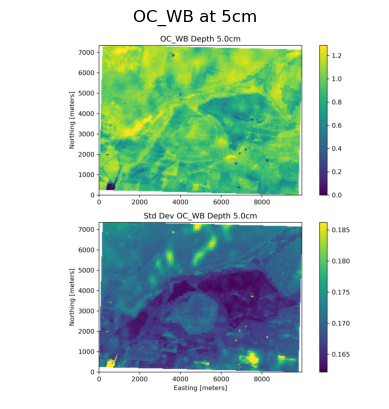

In [15]:
imgpath = os.path.join(settings.outpath, 'Figures_zslices')
files = os.listdir(imgpath)
# select depth png files
pngfiles = [name for name in files if name.endswith('cm.png')]
print('Image files generated: ', pngfiles)

nimg = len(pngfiles)
for i in range(len(pngfiles)):
    fig, ax = plt.subplots(1, dpi =100)
    img = imread(f"{imgpath}/{pngfiles[i]}", format='PNG')
    ax.set_axis_off()
    ax.imshow(img)
    ax.set_title(f'{settings.name_target} at {int(settings.list_z_pred[i]*100)}cm')
    fig.show()

## 2) Model and generate prediction for polygons

Now we generate predictions for hexagonal polygons (vector shapes given in file settings.polyname). This method calculates the prediction and its uncertainty for each polygon cell. This is done by averaging over all support points within each polygon cell and also taken into account the spatial covariance for computing the averaging uncertainty. Note that any polygon shapes can be provided such as paddock boundaries.

In [16]:
settings.integrate_polygon = True
settings.integrate_block = False

settings.outpath = os.path.join(outpath_root,'polygons')

print('Generating model and predictions for polygon...')
soilmod.model_polygons(settings)

print('')
print('Predictions finished')
print(f'All results are saved in output directory {settings.outpath}')

Generating model and predictions for polygon...
--- Parameter Settings ---
Model Function: blr-gp
Target Name: OC_WB
Prediction geometry: Polygon
--------------------------
Reading in data...
Preprocessing grid covariates and joining with polygon geometry...
Optimizing GP hyperparameters...
Mean Input Noise:  1.0247354310064152
Optimized Hyperparameters (amplitude, y_noise_fac, lengthscale_z, lengths_xy): [3.69518963e-01 1.66100351e-04 5.18091417e+01 2.99999991e+04]
Marginal Log Likelihood:  -224.99411248637662
Number of mini-batches per depth or time slice:  336
Computing slices at depth: 5.0cm


  4%|▍         | 14/336 [00:00<00:02, 134.17it/s]

Logl:  -224.99406231930146


100%|██████████| 336/336 [00:03<00:00, 99.59it/s] 


Plotting polygon map ...

Predictions finished
All results are saved in output directory results/Llara_predictions_static/polygons


### Show results for polygons

Here we show the polygon prediction results for the top soil (5cm mid-depth). The polygon shapes are hexagons, but can be any shape in vector-format as saved in the polygon input file.

The top panel shows the predictions for OC and the bottom panel of the figure represent the predicted standard deviation.


Image files generated:  ['Pred_Poly_OC_WB_z005cm.png']


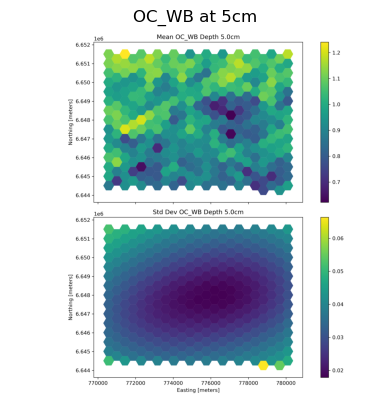

In [17]:
imgpath = os.path.join(settings.outpath, 'Figures_zslices')
files = os.listdir(imgpath)
# select depth png files
pngfiles = [name for name in files if name.endswith('cm.png')]
print('Image files generated: ', pngfiles)

nimg = len(pngfiles)
for i in range(len(pngfiles)):
    fig, ax = plt.subplots(1, dpi =100)
    img = imread(f"{imgpath}/{pngfiles[i]}", format='PNG')
    ax.set_axis_off()
    ax.imshow(img)
    ax.set_title(f'{settings.name_target} at {int(settings.list_z_pred[i]*100)}cm')
    fig.show()

## 3) Model and generate prediction for area blocks

Here we compare how these predictions compare to the block estimates. Similar to the polygon method, here we calculate the prediction and uncertainty for each areal block (here 100m size as specified in settings). This is done by averaging over all support points within each block and also taken into account the spatial covariance for computing the averaging uncertainty. 

In [18]:
settings.integrate_polygon = False
settings.integrate_block = True
settings.outpath = os.path.join(outpath_root,'blocks')

print('Generating model and predictions for blocks...')
soilmod.model_blocks(settings)
print('')
print('Predictions finished')
print(f'All results are saved in output directory {settings.outpath}')

Generating model and predictions for blocks...
Number of evaluation points per block:  44.44444444444444
--- Parameter Settings ---
Model Function: blr-gp
Target Name: OC_WB
Prediction geometry: Volume
x,y,z blocksize: (200, 200, 1)
--------------------------
Reading in data...
Optimizing GP hyperparameters...
Mean Input Noise:  1.0308519276604315
Optimized Hyperparameters (amplitude, y_noise_fac, lengthscale_z, lengths_xy): [3.82793372e-01 1.66100351e-04 5.50043898e+01 2.99999991e+04]
Marginal Log Likelihood:  -225.03920102781103
Computing slice at depth: 5.0cm


  2%|▏         | 37/1850 [00:00<00:05, 359.92it/s]

Logl:  -225.03912628005187


100%|██████████| 1850/1850 [00:08<00:00, 213.74it/s]



Predictions finished
All results are saved in output directory results/Llara_predictions_static/blocks


### Show results for blocks

Here we show the block prediction results for the top soil.

The top panel shows the predictions for OC and the bottom panel of the figure represent the predicted standard deviation.

Image files generated:  ['Pred_OC_WB_z005cm.png']


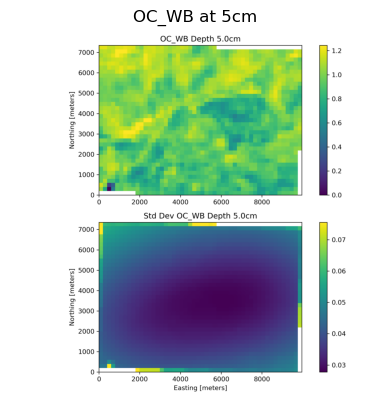

In [19]:
imgpath = os.path.join(settings.outpath, 'Figures_zslices')
files = os.listdir(imgpath)
# select depth png files
pngfiles = [name for name in files if name.endswith('cm.png')]
print('Image files generated: ', pngfiles)

nimg = len(pngfiles)
for i in range(len(pngfiles)):
    fig, ax = plt.subplots(1, dpi =100)
    img = imread(f"{imgpath}/{pngfiles[i]}", format='PNG')
    ax.set_axis_off()
    ax.imshow(img)
    ax.set_title(f'{settings.name_target} at {int(settings.list_z_pred[i]*100)}cm')
    fig.show()